# THIS is an old debugging notebook the most up to date version is found at qpc_dd_sim

In this notebook we build upon fermion_spin_hopping_qutip to try and build a QPC meassuring a single/double dot system. Here, we model the QPC as a thighbinding model with equal hopping everywhere except where its is hooked up to the double dot system via a quartic interaction. 

**This chain should be long enough that the wave packet does not bounce back before we see events in the double dot system**.

The double dot is isolated and we are also not considering dephasing anywhere. For this reason, **it may be better to use some Schrödinger equation solver rather than the full Lindbladian**. 


## What we could do here is write a cluster script that runs this like 100 times such that at each simulation we have an independent electron interacting with the double dot. We could then average over that 

In [1]:
import numpy as np

from scipy.fft import fft, fftfreq, fftshift
from scipy.integrate import simpson
import matplotlib.pyplot as plt
import seaborn as sns
from qutip import  *
import os
import sys
import h5py
import json

import matplotlib

# add path to project dir so we can include custom modules from src
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

sys.path.insert(0, parent_path)

from src.qutip_tools import *


In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 18

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/QPC_double_dot/"


In [3]:
def gen_gauss_init(l0, sigma, Nsites, k0=0):
    # creates a gaussian initial condition centerd on l0 with bandwidth sigma for Nsites
    # and initial velocity k0

    x = np.asarray(range(0,Nsites))
    coefs = ((np.sqrt(np.pi)*sigma)**(-0.5))*np.exp(-0.5*(x-l0)**2/(sigma**2) )*np.exp(1j*k0*(x-l0))
    
    # normalize
    mag = np.dot(np.conjugate(coefs),coefs)
    coefs = coefs/np.sqrt(mag)
    
    return coefs    

In [4]:
def get_qpc_H(op_list, Nsites, Nqpc,jcouple):
    # create the Hamiltonian for the QPC where Nsites includes the double dot
    # and Nqpc only has the qpc site
    ident_tensor = tensor([identity(2)]*(Nsites)) 
    H = 0*ident_tensor

    for site_j in range(0,Nqpc-1):
        H += -jcouple[site_j]*(op_list[site_j].dag()*op_list[site_j+1]+
                                   op_list[site_j+1].dag()*op_list[site_j])
    return H 
    
def gen_QPC_dot_basis(L_QPC, Center_index, Band_w, Kinit):
    # Combines the 1particle bassi of the QPC and the dot to get the full psi

    # L_QPC: integer, length of qpc lattice
    # Center_index: integer, indicates the lattice site where QPC is initialized
    # Band_w: float, band width of the gaussian qave packet in the qpc
    # Kinit: float, group velocity of the gaussian wave packet

    # create the 1 particle basis and the coeficients for the initial state
    str_list, basis_list = get_1p_basis(L_QPC)
    # build the initial condition for the QPC
    qpc_init = gen_gauss_init(Center_index, Band_w, L_QPC, k0=Kinit)

    psi_qpc = [qpc_init[j]*basis_list[j] for j in range(0,len(qpc_init))]

    # create the dot basis
    dot_basis = [tensor(basis(2,0),basis(2,1)), tensor(basis(2,1),basis(2,0))]
    # build the initial condition for the dot
    dot_init = [0.0, 1.0]
    psi_dot = [dot_basis[j]*dot_init[j] for j in range(0,len(dot_basis))]

    # assume dot initial state completely independent from QPC init state so we can factorize the probas
    full_basis = []
    # combine them 
    for i in range(0,len(basis_list)):
        for j in range(0, len(dot_basis)):
            full_basis.append(tensor([psi_qpc[i], psi_dot[j]]))

    # state correspond to particle in qpc all the way to the left and particle on left dot
    Psi0 = np.sum(full_basis)
    Psi0 = Psi0.unit()   
    
    return Psi0, qpc_init
    

In [5]:
# location where the raw data is saved
data_route = "../data/sims/"
fig_route = "../plots/QPC_double_dot/"

L_qpc = 18  # lenth of the QPC chain
L = L_qpc+2 # QPC times double dot 
max_t = 10 # maximum time
tsteps = 300 # number of time steps
bond_index = int(L_qpc/2) # dangling bond between bond_index and bond_index+1
gamma = 0.0
centered_at = 0 # initial QPC position of wavepacket
band_width = 2.0 # width of the gaussian wave packet larger bandwidth means less lattice localizaiton
K0 = 1.0 # Initial velocity of the wavepacket
J_prime = 1.0 # contact to double dot
t = 0.2 # hopping between quantum dots 
Omega = 0.5 # coupling between dot 1 and QPC

# dot energies not yet implemented
E1 = 0.0
E2 = 0.0
epsilon = np.zeros(L_qpc) # energies of the QPC chains 

epsilon[:bond_index] = 0.0 # source energies
epsilon[bond_index:] = 0.0 # drain energies
J = np.ones(L_qpc) # QPC hopping
# this means that I am putting the dangling bond between sites int(L_qpc/2) and int(L_qpc/2)+1
# where the interaction to the double dot is also located
J[bond_index] = J_prime  


## Initial conditions

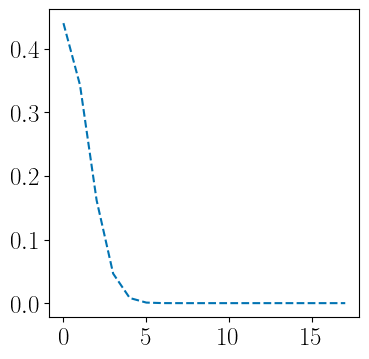

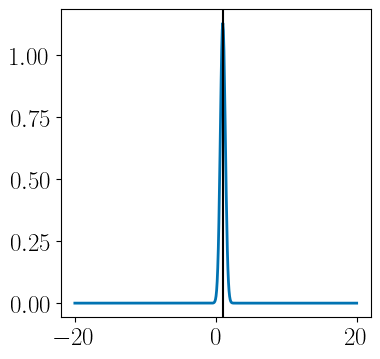

In [6]:
psi0, qpc_init = gen_QPC_dot_basis(L_qpc, centered_at, band_width, K0)
# create the fermion operator list
c_list = [fdestroy(L,i) for i in range(0,L)]

# we can also calcualte the fourier transform of the initial gaussian to see
# the momentum distribution
k_arr = np.linspace(-20,20,500)
Psi0k = (band_width**2/np.pi)**(1/4)*np.exp(-(0.5*band_width**2)*(k_arr-K0)**2 + 1j*k_arr*centered_at)

# visualize the initial condition of the qpc
fig, ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(range(0,L_qpc),np.abs(qpc_init)**2, linestyle = "dashed")

fig, ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(k_arr,np.abs(Psi0k)**2, linestyle = "solid", linewidth=2)
ax.axvline(K0,c='black')

## Solution

In [7]:
# create the hamiltonian start with qpc
H_QC = get_qpc_H(c_list, L ,L_qpc,J)

# double dot H
Hdot = -t*(c_list[-1].dag()*c_list[-2] + c_list[-2].dag()*c_list[-1])

# interaction H
Hint =  Omega*c_list[-2].dag()*c_list[-2]*( c_list[bond_index].dag()*c_list[bond_index+1] +
                                          c_list[bond_index+1].dag()*c_list[bond_index])

H = H_QC + Hdot  + Hint

print(H_QC.isherm, Hdot.isherm, Hint.isherm, H.isherm)

# get the operators needed for lindbladian 
# hrtr we don't really want dephasing but just put it there for now
collapse_ops, expect_ops = create_lindblad_op(L, c_list, gamma)
# add the energy to also track it
expect_ops.append(H)


times = np.linspace(0.0, max_t, tsteps)
# solve for operators
result = sesolve(H, psi0, times, e_ops=expect_ops)
# solve for state
# result_psi = sesolve(H, psi0, times)

print(result)



True True True True
<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.00021409988403320312
    preparation time: 0.7411119937896729
    run time: 81.30509185791016
    solver: 'Schrodinger Evolution'
  Time interval: [0.0, 10.0] (300 steps)
  Number of e_ops: 21
  State not saved.
>


In [8]:
"""# for plotting SMALL Hamiltonians
fig, ax = hinton(H)
ax.tick_params(axis='both', which='major', labelsize = 7)
ax.tick_params(axis='x', rotation=90)"""


"# for plotting SMALL Hamiltonians\nfig, ax = hinton(H)\nax.tick_params(axis='both', which='major', labelsize = 7)\nax.tick_params(axis='x', rotation=90)"

In [9]:
# exclude the sites at Lp/2 and Lp/2 +1 where the bond is located
n_left = np.sum(result.expect[:bond_index], axis=0)
# the minus 3 is because we  leave out the energy and dot occupations
n_right = np.sum(result.expect[bond_index+2:-3], axis=0)
# occupation in the bond
n_bond = result.expect[int(bond_index)] + result.expect[bond_index+1] 


# Comparisson with the decoupled case

##  Exact $\psi$ in the QPC

Taken from: https://physics.stackexchange.com/questions/709973/open-boundary-condition-in-hubbard-model

The eigenbasis of the tight binding QPC Hamiltonian with the double dot interaction is in k-space


In [10]:
k_arr = (np.pi/(L_qpc+1))*np.arange(1,L_qpc+1)
Ek_arr = -2*np.cos(k_arr) # eigenenergies
vk_arr = np.zeros((L_qpc, len(k_arr)))# eigenvalues 
# create the eigenvectors:
for k in range(0,len(k_arr)):
    # first index is lattice site second index are k-momenta
    vk = np.sin(k_arr[k]*np.arange(1,L_qpc+1))
    # normalize 
    mag2 = np.dot(vk,vk)
    vk_arr[:,k] = vk/np.sqrt(mag2)

# express the time evolution of the occupation psi in terms of the eigenvectors by changing basis
psi_t = np.zeros((L_qpc, len(times)),dtype=complex) # first index is lattice site, second is time
psi_t[:,0] = qpc_init

# time evolution
for t_index in range(1,len(times)):
    # basis change
    for k_index in range(0,len(k_arr)):
        tt = times[t_index]
        psi_t[:,t_index] += np.dot(qpc_init,vk_arr[:,k_index])*np.exp(-1j*tt*Ek_arr[k_index])*vk_arr[:,k_index]
   
psi_probas = np.abs(psi_t)**2


## Trajectories

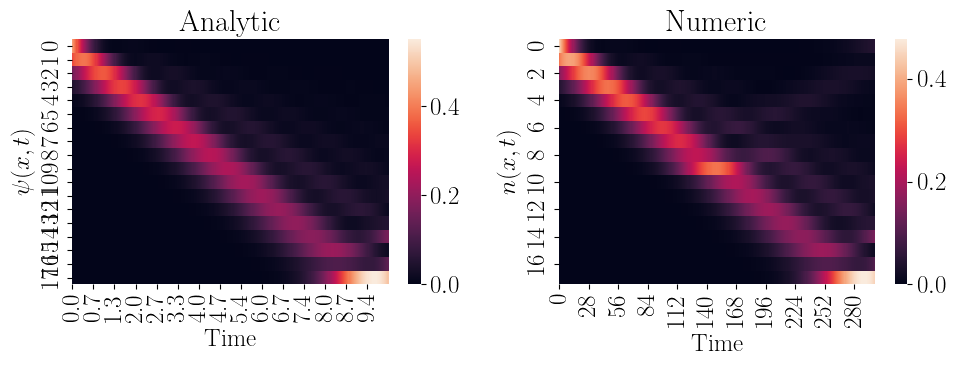

In [11]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.heatmap(psi_probas, ax=ax[0])

# ANALYTICAL RESULT
ax[0].set_title("Analytic")
ax[0].set_xlabel("Time")
ax[0].set_ylabel(r"$\psi (x,t)$");

# lattice ticks
site_ticks = list(range(0,L_qpc))
tick_posy = np.asarray(range(0,len(site_ticks))) + 0.5
ax[0].set_yticks(tick_posy,site_ticks);

# time ticks
delta_tau = times[1]- times[0]
tick_posx = np.arange(0,len(times),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)
ax[0].set_xticks(tick_posx,xtick_label);
ax[1].set_xticks(tick_posx,xtick_label);

# NUMERICAL RESULT
sns.heatmap(result.expect[:-3], ax=ax[1])

ax[1].set_title("Numeric")
ax[1].set_xlabel("Time")
ax[1].set_ylabel(r"$n(x,t)$");

plt.tight_layout()
#plt.savefig(fig_route+"decoupled_trajectories_analytic_comp.png")


Text(0, 0.5, '$\\rm{Analytical } \\psi(t) $')

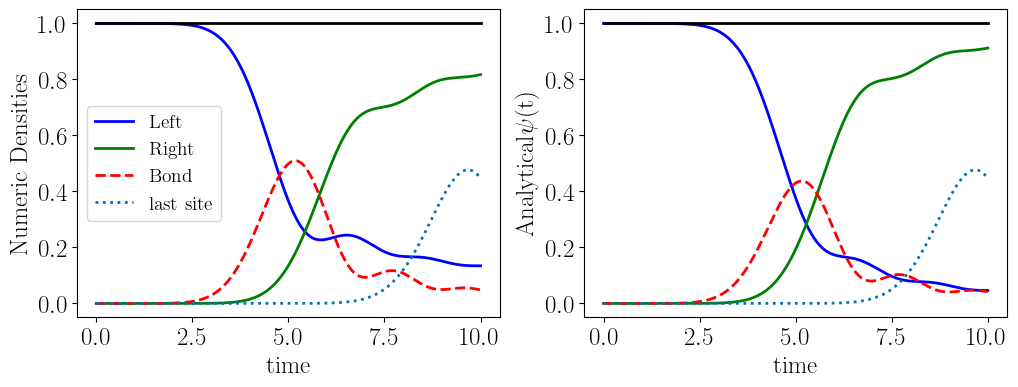

In [12]:
# exclude the sites at Lp/2 and Lp/2 +1 where the bond is located
n_left = np.sum(result.expect[:bond_index], axis=0)
# the minus 3 is because we  leave out the energy and dot occupations
n_right = np.sum(result.expect[bond_index+2:-3], axis=0)
# occupation in the bond
n_bond = result.expect[int(bond_index)] + result.expect[bond_index+1] 

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(times, n_left, label="Left", c='blue', linewidth=2)
ax[0].plot(times,n_right,label="Right", c='green',linewidth=2)
ax[0].plot(times,n_bond,label="Bond", linestyle="dashed", c='red',linewidth=2)
ax[0].plot(times,result.expect[-4],label="last site", linestyle="dotted",linewidth=2)
ax[0].plot(times,n_left+n_right+n_bond, c = 'black',linewidth=2)
ax[0].set_xlabel("time")
ax[0].set_ylabel("Numeric Densities")
ax[0].legend()

# now we do the same but for the analytical results

n_left = np.sum(psi_probas[:bond_index,:], axis=0)
n_right = np.sum(psi_probas[bond_index+2:,:], axis=0)
n_bond = psi_probas[bond_index,:] + psi_probas[bond_index+1,:] 

ax[1].plot(times, n_left, label="Left", c='blue', linewidth=2)
ax[1].plot(times,n_right,label="Right", c='green',linewidth=2)
ax[1].plot(times,n_bond,label="Bond", linestyle="dashed", c='red',linewidth=2)
ax[1].plot(times,result.expect[-4],label="last site", linestyle="dotted",linewidth=2)
ax[1].plot(times,n_left+n_right+n_bond, c = 'black',linewidth=2)
ax[1].set_xlabel("time")
ax[1].set_ylabel(r"$\rm{Analytical } \psi(t) $")


## Rabi Oscillations in the double dot

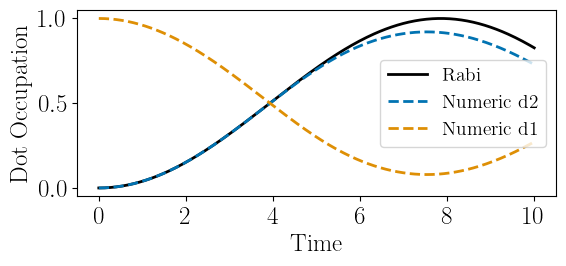

In [13]:
fig, ax = plt.subplots(1,1, figsize=(6,3),sharex=True)
wr = t
rabi_osc = np.sin(wr*times)**2

# in dot
ax.plot(times, rabi_osc, linewidth=2.0, alpha=1.0, c='black' ,label="Rabi")
ax.plot(times, result.expect[-2], linewidth=2.0, alpha=1.0, linestyle="dashed" ,
        label="Numeric d2")

ax.plot(times, result.expect[-3], linewidth=2.0, alpha=1.0, linestyle="dashed" ,
        label="Numeric d1")

plt.ylabel("Dot Occupation")
plt.xlabel("Time")

plt.legend()
plt.tight_layout()
#plt.savefig(fig_route+"decoupled_rabi_analytic_comp.png")

